Joyce Wang

10/25/2025-10/26/2025

Referring to `Python_exploring_h5ad_files.ipynb` and the [Scanpy Preprocessing and clustering tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#nearest-neighbor-graph-construction-and-visualization).

**This notebook includes:**
- Reading in h5ad files in our dataset
- Figuring out variable names in our adata and seeing if using ad.concat() + adding a `sample` column, vs. using sc.concat(), affects things downstream
- Exploring adata
- Examining the cell labels in the cell metadata (adata.obs['AIFI_L2']) to see if any labels are underrepresented in any of the drug treatments
     - Visualizing with bar charts and heatmaps
-  Scanpy preprocessing, dimensionality reduction (PCA, UMAPs) and clustering

In [1]:
# Core libraries
import hisepy
import scanpy as sc
import anndata as ad
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape sequence '\s'
  .. math:: Q = \sum_k \\lambda_k Q_k.


# Read in .h5ad files in our File Set

In [2]:
h5ad_files = hisepy.cache_fileset('f48bf688-1a5f-456c-b0b0-c6ec870ec003')

In [3]:
# view the first five file names
h5ad_files[0:5]

['/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Afatinib_BIBW2992_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Afatinib_dimaleate_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Baricitinib_LY3009104_INCB028050_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Baricitinib_phosphate_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Canertinib_CI-1033_counts_filtered_labeled_sampled.h5ad']

In [4]:
# initialize a list
adata_list = []

# iterate over the list h5ad_files to use Scanpy to read the file
for h5ad_file in h5ad_files:
    adata = sc.read_h5ad(h5ad_file)
    # append anndata file object into the list
    adata_list.append(adata)

In [5]:
# view the first item of the list
adata_list[0]

AnnData object with n_obs × n_vars = 25000 × 1916
    obs: 'original_barcodes', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_umis', 'n_genes', 'plate_location', 'cyto_treatment', 'drug_treatment', 'drug_name', 'drug_cas_number', 'drug_mw', 'drug_solvent', 'drug_pathway', 'drug_target', 'drug_description', 'drug_chembl_name', 'drug_chembl_id', 'AIFI_L1', 'AIFI_L2', 'leiden_2'
    uns: 'drug_name_colors', 'leiden_2', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## ad.concat() vs. sc.concat(), and meaning/use of a `sample` column:

**QUESTION: Does using this chunk of code with `ad.concat` from the Scanpy tutorial change how adata looks compared to if I used `sc.concat` from `Python_exploring_h5ad_files.ipynb`?**
- I'm guessing if I use that code chunk with `ad.concat` from the Scanpy tutorial, I'm labelling a "sample" column and making sure I'm getting unique observation names (cell IDs).
- This could affect the dimensionality reduction and clustering part of this notebook (and downstream).
- NOTE: I'm pretty sure this `sample` column is the same thing as the `drug_name` column, as there are 18 samples (18 drug names).
- Because `sample` is basically `drug_name`, I can also use `sc.concat` like from the Jupyter Notebook-- and just replace any instance where I see `sample` being graphed with `drug_name` during dimensionality reduction and clustering.
- Basically: following either the Scanpy tutorial or Jupyer notebook tutorial here for concatenation will work. If I follow the Scanpy tutorial, the new `sample` column is essentially the `drug_name`.

In [6]:
# using anndata to concatenate: code chunk from Scanpy tutorial

# combine multiple anndata objects and adds a "sample" column telling you which dataset each cell came from; aka, which DRUG NAME each cell was treated with!
adata = ad.concat(adata_list, label="sample")

# make sure all observations are unique
adata.obs_names_make_unique()

# show how many cells there are per sample, or per drug name!
print(adata.obs["sample"].value_counts())
print(adata.obs["drug_name"].value_counts())

adata

/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/anndata/_core/merge.py:1667: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(


sample
0     25000
1     25000
2     25000
3     25000
4     25000
5     25000
6     25000
7     25000
8     25000
9     25000
10    25000
11    25000
12    25000
13    25000
14    25000
15    25000
16    25000
17    25000
Name: count, dtype: int64
drug_name
Afatinib (BIBW2992)                    25000
Afatinib dimaleate                     25000
Baricitinib (LY3009104, INCB028050)    25000
Baricitinib phosphate                  25000
Canertinib (CI-1033)                   25000
Canertinib dihydrochloride             25000
DMSO Control                           25000
Erlotinib                              25000
Erlotinib Hydrochloride                25000
Gefitinib (ZD1839)                     25000
Gefitinib hydrochloride                25000
IL6 Control                            25000
NVP-BSK805                             25000
NVP-BSK805 2HCl                        25000
Ruxolitinib (INCB018424)               25000
Ruxolitinib phosphate                  25000
Tofacitinib (CP-69055

AnnData object with n_obs × n_vars = 450000 × 1916
    obs: 'original_barcodes', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_umis', 'n_genes', 'plate_location', 'cyto_treatment', 'drug_treatment', 'drug_name', 'drug_cas_number', 'drug_mw', 'drug_solvent', 'drug_pathway', 'drug_target', 'drug_description', 'drug_chembl_name', 'drug_chembl_id', 'AIFI_L1', 'AIFI_L2', 'leiden_2', 'sample'
    obsm: 'X_pca', 'X_umap'

From running `ad.concat()` like in the Scanpy tutorial, I saw how many cells there are per sample-- and it was all-around 25,000 cells per sample.

In [7]:
# using scanpy to concatenate: from Python_exploring_h5ad_files.ipynb.

# adata = sc.concat(adata_list)
# adata

In [8]:
# len(adata_list) for how many files are in the list: 18, for 8 drugs with 2 formulas each and 2 controls
len(adata_list)

18

**The data contains 25,000 cells per sample, 18 samples (for 8 drugs with 2 formulas each and 2 controls), 450,000 observations (total cells), and 1,916 measured genes.**

# Let's keep exploring adata!

In [9]:
# create a copy of adata
obs = adata.obs.copy()

### Notes on exploring adata:

Use `.obs`to explore the data more by pulling out the columns you need and getting the counts!

For example: `adata.obs[['drug_name']].value_counts()` gives us information about the drug treatments (drug names).
- Some drugs have 50000 counts instead of 25000-- those probably point at duplicates of the same drug.
- I get the exact same thing with `adata.obs[['sample']].value_counts()`.

You can replace 'drug_name' with other columns from adata that gives more information about each drug, such as 'drug_cas_number', 'drug_solvent', 'drug_pathway', 'drug_target', 'drug_description', 'drug_chembl_name or id'

Another example: `adata.obs[[‘AIFI_L2’]].value_counts()` gives us information about AIFI_L1 or AIFI_L2.
- AIFI_L1 and AIFI_L2 are information about the cell type / T cells, the L2 is what we will be using more (more specific) while L1 is more of a broad overview 


In [10]:
# obs[['drug_name']].value_counts() # 18 drug names, for 8 drugs with 2 formulas each and 2 controls

In [11]:
obs[['drug_name', 'drug_treatment', 'drug_description']].value_counts()

drug_name                            drug_treatment  drug_description                                 
Afatinib (BIBW2992)                  A8247           Irreversible EGFR/HER2 inhibitor                     25000
Afatinib dimaleate                   A3145           EGFR inhibitor                                       25000
Baricitinib (LY3009104, INCB028050)  A4141           JAK1/JAK2 inhibitor,selective orally bioavailable    25000
Baricitinib phosphate                A3222           JAK1/JAK2 inhibitor                                  25000
Canertinib (CI-1033)                 A1845           HER family tyrosine kinase inhibitor                 25000
Canertinib dihydrochloride           A3276           Pan-ErbB inhibitor, potent and selective             25000
Erlotinib                            A3397           EGFR tyrosine kinase inhibitor                       25000
Erlotinib Hydrochloride              A8234           Selective EGFR inhibitor                             25000
G

In [12]:
obs[['AIFI_L2']].value_counts()

AIFI_L2            
CD4 Naive              118058
CD4 Central Memory     107272
CD8 Naive               78553
CD4 Effector Memory     49677
CD8 Effector Memory     39593
CD8 Central Memory      25655
Treg                    22905
MAIT                     8262
CD8aa                      25
Name: count, dtype: int64

# Examine the cell labels in the cell metadata (adata.obs['AIFI_L2']) to see if any labels are underrepresented in any of the drug treatments.

**I believe we should pull out the column `AIFI_L2` for cell type labels, and the column `drug_name` for drug treatments.**

Or do we pull out `drug_treatments" for drug treatments? (Probably not, but I graphed this anyway just to see)

In [13]:
count_types_per_treatment2 = obs[['drug_treatment', 'AIFI_L2']].value_counts()
count_types_per_treatment2


# convert to a dataframe
count_df2 = pd.DataFrame(count_types_per_treatment2)
# count_df2

In [14]:
count_types_per_treatment = obs[['drug_name', 'AIFI_L2']].value_counts()
count_types_per_treatment

# convert to a dataframe
count_df = pd.DataFrame(count_types_per_treatment)
count_df

# for just dividing by the maximum value
count_df['normalized_count'] = count_df.groupby('AIFI_L2').transform(lambda x: x / max(x))

# for rescaling so min = 0 and max = 1
# count_df['rescaled_count'] = count_df.groupby('AIFI_L2').transform(lambda x: (x - min(x))/(max(x) - min(x)))

/tmp/ipykernel_153/349478457.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df['normalized_count'] = count_df.groupby('AIFI_L2').transform(lambda x: x / max(x))


## Bar plot to see if any cell labels are underrepresented:

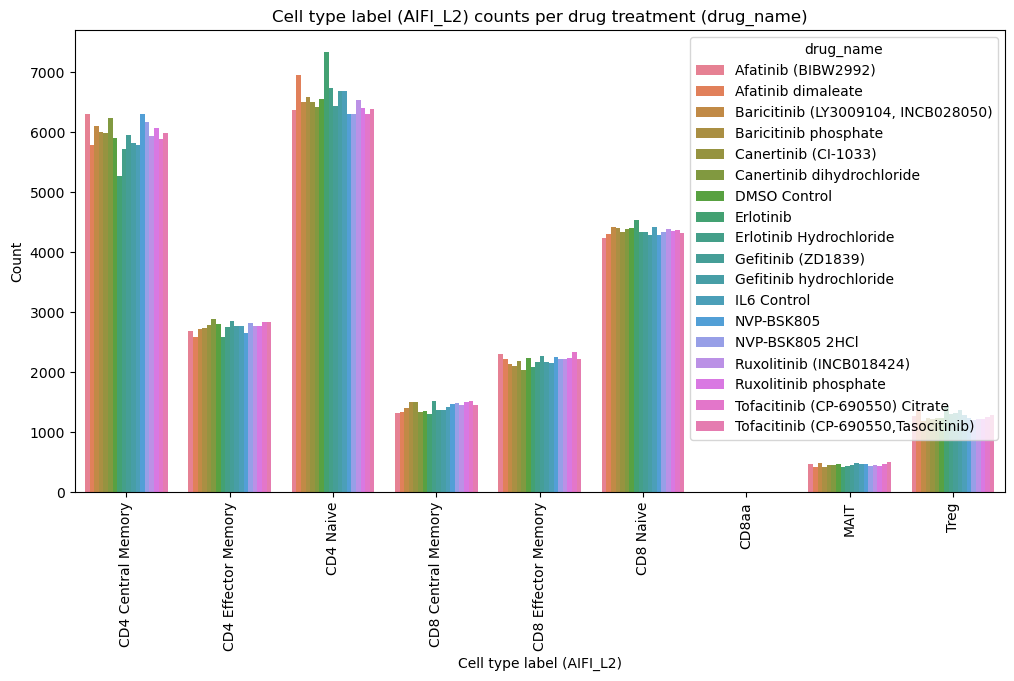

In [15]:
# bar plot:
# x-axis is cell type labels AIFI_L2
# y-axis is count
# hue, what we're grouping by, is drug_name

plt.figure(figsize = (12, 6))
sns.barplot(data = count_df, x = "AIFI_L2", y = "count", hue = "drug_name")
plt.xticks(rotation = 90)
plt.title("Cell type label (AIFI_L2) counts per drug treatment (drug_name)")
plt.xlabel("Cell type label (AIFI_L2)")
plt.ylabel("Count")
plt.show()

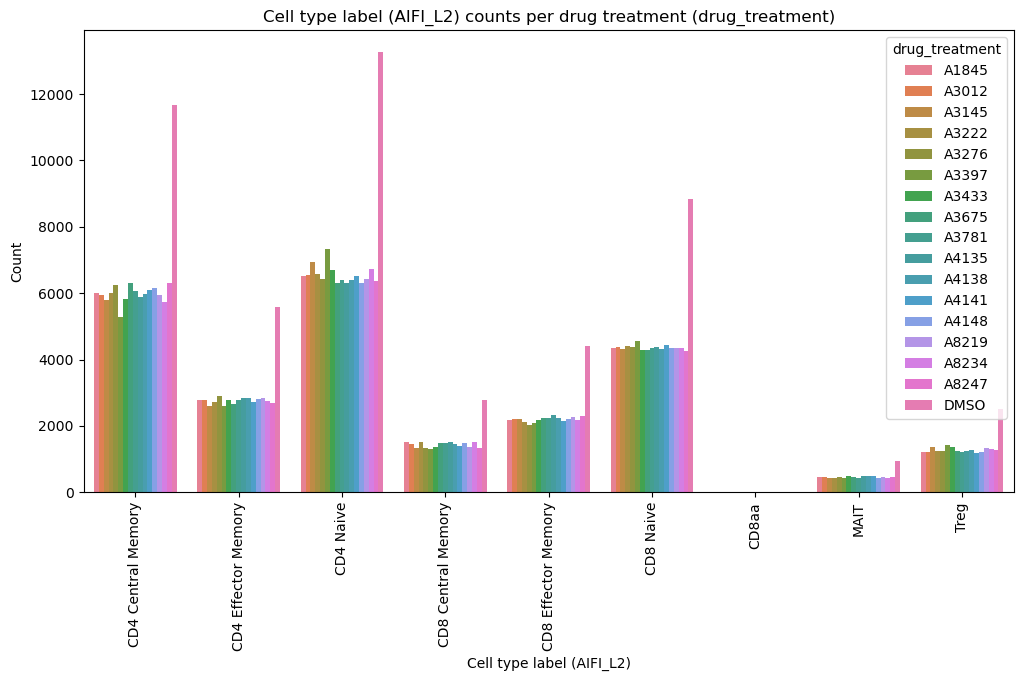

In [16]:
# bar plot:
# x-axis is cell type labels AIFI_L2
# y-axis is count
# hue, what we're grouping by, is drug_treatment

plt.figure(figsize = (12, 6))
sns.barplot(data = count_df2, x = "AIFI_L2", y = "count", hue = "drug_treatment")
plt.xticks(rotation = 90)
plt.title("Cell type label (AIFI_L2) counts per drug treatment (drug_treatment)")
plt.xlabel("Cell type label (AIFI_L2)")
plt.ylabel("Count")
plt.show()

It seems like the cell label "CD8aa" is underrepresented as well as MAIT and Treg.

## Heatmap to see if any cell labels are underrepresented:

In [17]:
# heatmap: requires a matrix.

# convert dataframe to a matrix:
# "index" will be the rows of the heatmap (the 18 drug treatments (drug_names))
# "columns" will be the columns (the cell labels (AIFI_L2))
# "values" will determine the color intensity (count)
    # aggfunc: apply sum() function to aggregate the "values" (count) by
count_pivot = count_df.pivot_table(
    index = "drug_name",
    columns = "AIFI_L2",
    values = "count",
    aggfunc = "sum",
    fill_value = 0
)

count_pivot

/tmp/ipykernel_153/2815048158.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_pivot = count_df.pivot_table(


AIFI_L2,CD4 Central Memory,CD4 Effector Memory,CD4 Naive,CD8 Central Memory,CD8 Effector Memory,CD8 Naive,CD8aa,MAIT,Treg
drug_name,,,,,,,,,
Afatinib (BIBW2992),6312,2695,6370,1324,2311,4247,2,469,1270
Afatinib dimaleate,5793,2596,6949,1337,2216,4312,1,426,1370
"Baricitinib (LY3009104, INCB028050)",6107,2727,6510,1405,2140,4429,1,484,1197
Baricitinib phosphate,6005,2732,6583,1508,2105,4406,1,425,1235
Canertinib (CI-1033),5994,2785,6512,1502,2192,4344,0,450,1221
Canertinib dihydrochloride,6237,2891,6424,1333,2040,4384,0,448,1243
DMSO Control,5899,2808,6564,1356,2241,4400,13,479,1240
Erlotinib,5268,2591,7335,1311,2095,4546,1,420,1433
Erlotinib Hydrochloride,5721,2763,6739,1523,2171,4344,1,439,1299


In [18]:
# and making another one for normalized counts
norm_count_pivot = count_df.pivot_table(
    index = "drug_name",
    columns = "AIFI_L2",
    values = "normalized_count",
    aggfunc = "sum",
    fill_value = 0
)

norm_count_pivot

/tmp/ipykernel_153/1021859430.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  norm_count_pivot = count_df.pivot_table(


AIFI_L2,CD4 Central Memory,CD4 Effector Memory,CD4 Naive,CD8 Central Memory,CD8 Effector Memory,CD8 Naive,CD8aa,MAIT,Treg
drug_name,,,,,,,,,
Afatinib (BIBW2992),1.000000,0.932203,0.868439,0.869337,0.987607,0.934228,0.153846,0.934263,0.886253
Afatinib dimaleate,0.917776,0.897959,0.947376,0.877873,0.947009,0.948526,0.076923,0.848606,0.956036
"Baricitinib (LY3009104, INCB028050)",0.967522,0.943272,0.887526,0.922521,0.914530,0.974263,0.076923,0.964143,0.835311
Baricitinib phosphate,0.951362,0.945002,0.897478,0.990151,0.899573,0.969204,0.076923,0.846614,0.861828
Canertinib (CI-1033),0.949620,0.963334,0.887798,0.986211,0.936752,0.955565,0.000000,0.896414,0.852059
Canertinib dihydrochloride,0.988118,1.000000,0.875801,0.875246,0.871795,0.964364,0.000000,0.892430,0.867411
DMSO Control,0.934569,0.971290,0.894888,0.890348,0.957692,0.967884,1.000000,0.954183,0.865318
Erlotinib,0.834601,0.896230,1.000000,0.860801,0.895299,1.000000,0.076923,0.836653,1.000000
Erlotinib Hydrochloride,0.906369,0.955725,0.918746,1.000000,0.927778,0.955565,0.076923,0.874502,0.906490


In [19]:
count_pivot2 = count_df2.pivot_table(
    index = "drug_treatment",
    columns = "AIFI_L2",
    values = "count",
    aggfunc = "sum",
    fill_value = 0
)

# count_pivot2

/tmp/ipykernel_153/2931076330.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_pivot2 = count_df2.pivot_table(


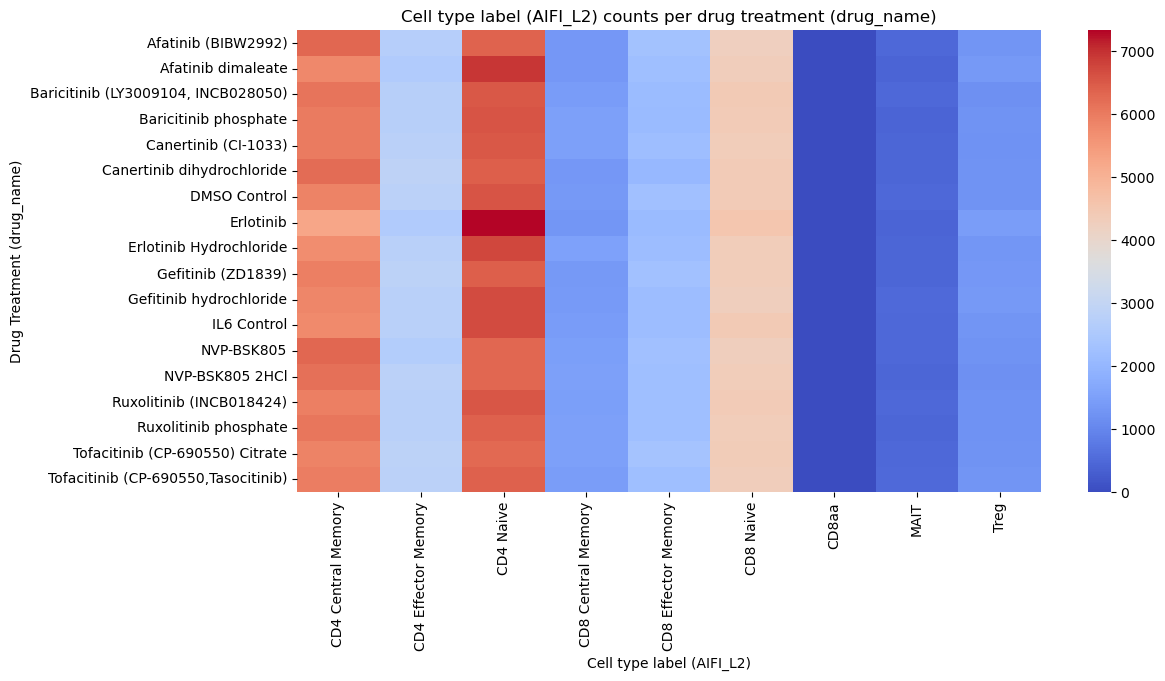

In [20]:
plt.figure(figsize = (12, 6))
sns.heatmap(data = count_pivot, cmap = "coolwarm")
plt.xticks(rotation = 90)
plt.title("Cell type label (AIFI_L2) counts per drug treatment (drug_name)")
plt.xlabel("Cell type label (AIFI_L2)")
plt.ylabel("Drug Treatment (drug_name)")
plt.show()

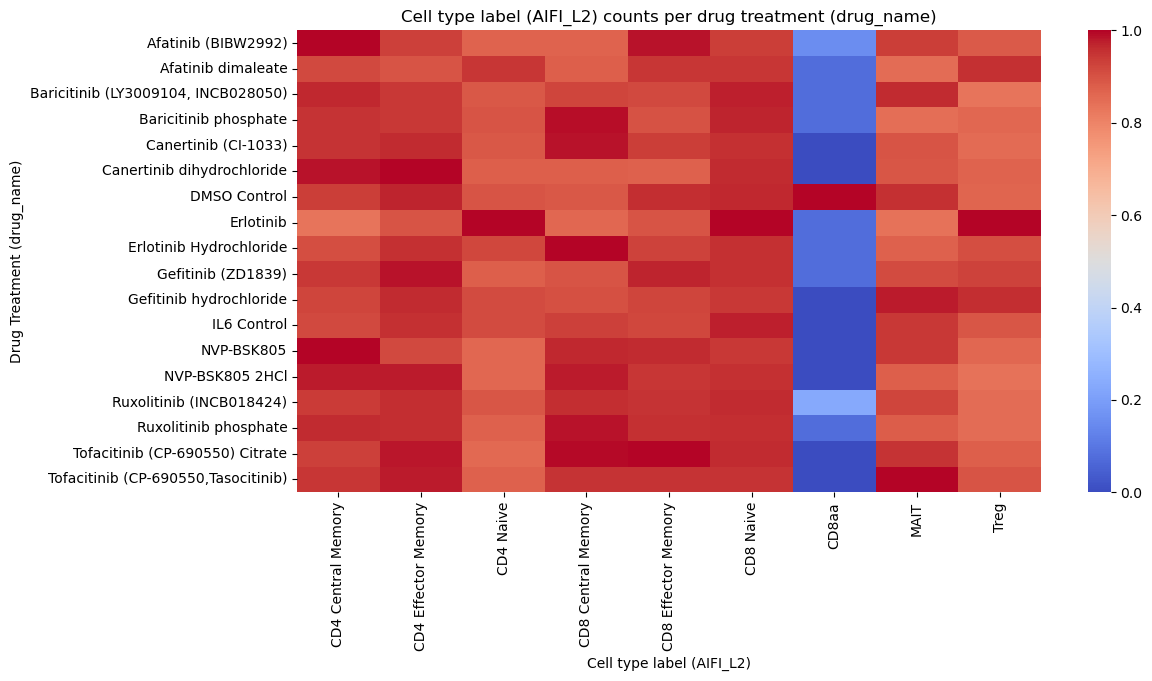

In [21]:
plt.figure(figsize = (12, 6))
sns.heatmap(data = norm_count_pivot, cmap = "coolwarm")
plt.xticks(rotation = 90)
plt.title("Cell type label (AIFI_L2) counts per drug treatment (drug_name)")
plt.xlabel("Cell type label (AIFI_L2)")
plt.ylabel("Drug Treatment (drug_name)")
plt.show()

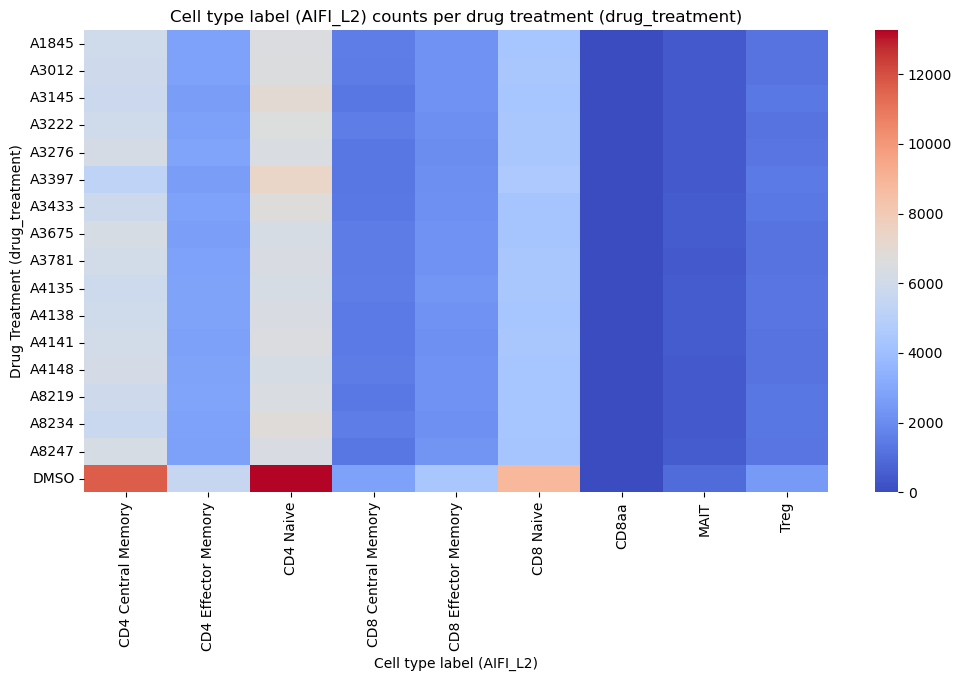

In [22]:
plt.figure(figsize = (12, 6))
sns.heatmap(data = count_pivot2, cmap = "coolwarm")
plt.xticks(rotation = 90)
plt.title("Cell type label (AIFI_L2) counts per drug treatment (drug_treatment)")
plt.xlabel("Cell type label (AIFI_L2)")
plt.ylabel("Drug Treatment (drug_treatment)")
plt.show()

Again, it seems like the cell labels CD8aa, MAIT, Treg, and possibly CD8 Central Memory are underpresented.

# Scanpy Preprocessing, Dimensionality Reduction & Clustering

## Normalization

In [23]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum = 1e4)

# Logarithmize the data
sc.pp.log1p(adata)
# sc.pp.scale(adata)

## Feature Selection

`pp.highly_variable_genes` annotates highly variable genes.

In [24]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample") 

# if following Scanpy tutorial's ad.concat(adata_list, label="sample") --> batch_key can be "sample", like in the Scanpy tutorial
# if using sc.concat(adata_list) --> batch_key should be "batch_id"

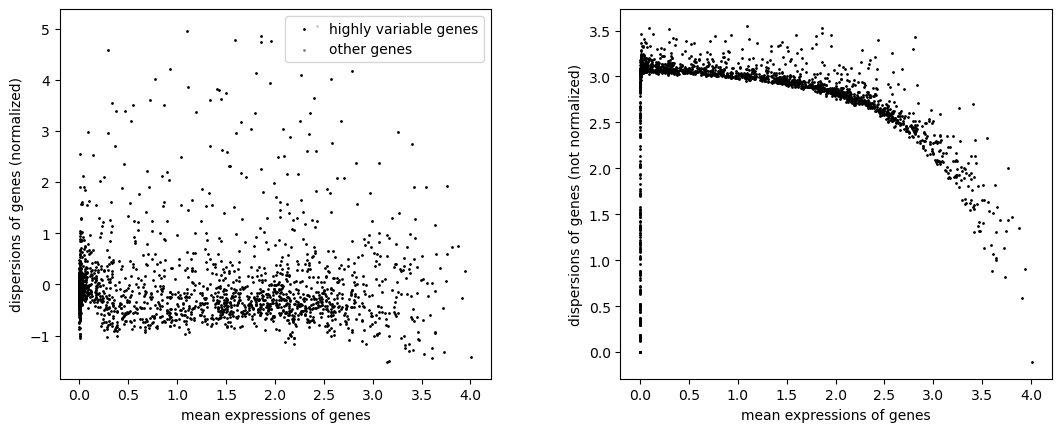

In [25]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction: PCA, UMAPs

In [26]:
# Reduce the dimensionality of the data by running principal component analysis (PCA)
sc.tl.pca(adata)

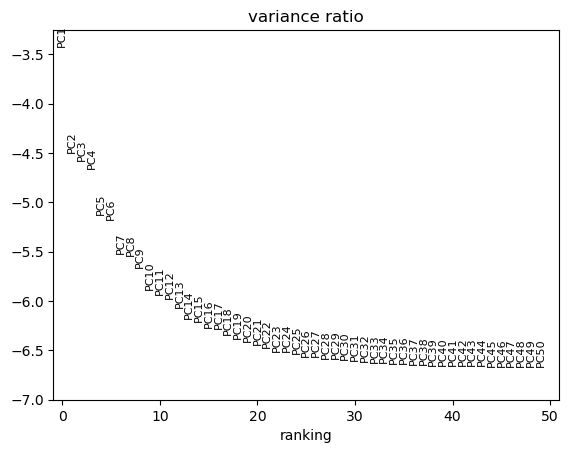

In [27]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

From Scanpy tutorial: "You can also plot the principal components to see if there are any potentially undesired features (e.g. batch, QC metrics) driving signifigant variation in this dataset."

**QUESTION ABOUT INTERPRETATION: is `sample` just `drug_name`? I'm pretty sure.: Check for batch effects:**

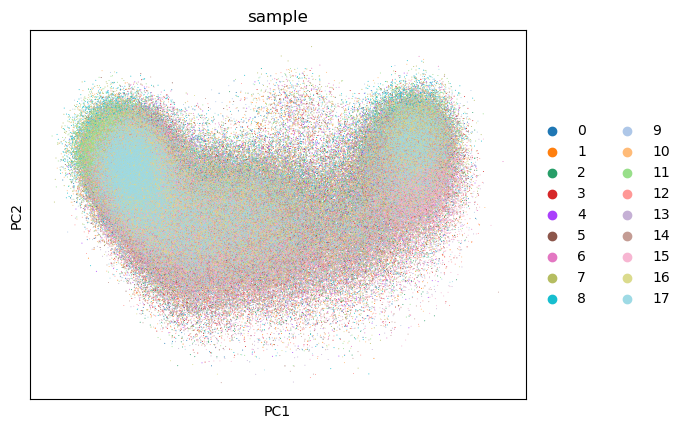

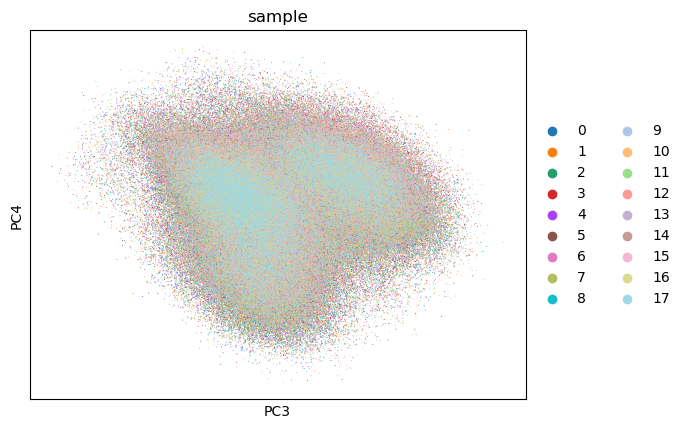

In [28]:
sc.pl.pca(
    adata,
    color = ["sample"],
    dimensions=[(0, 1)],
    ncols=2,
    size=2
)

sc.pl.pca(
    adata,
    color = ["sample"],
    dimensions=[(2, 3)],
    ncols=2,
    size=2
)

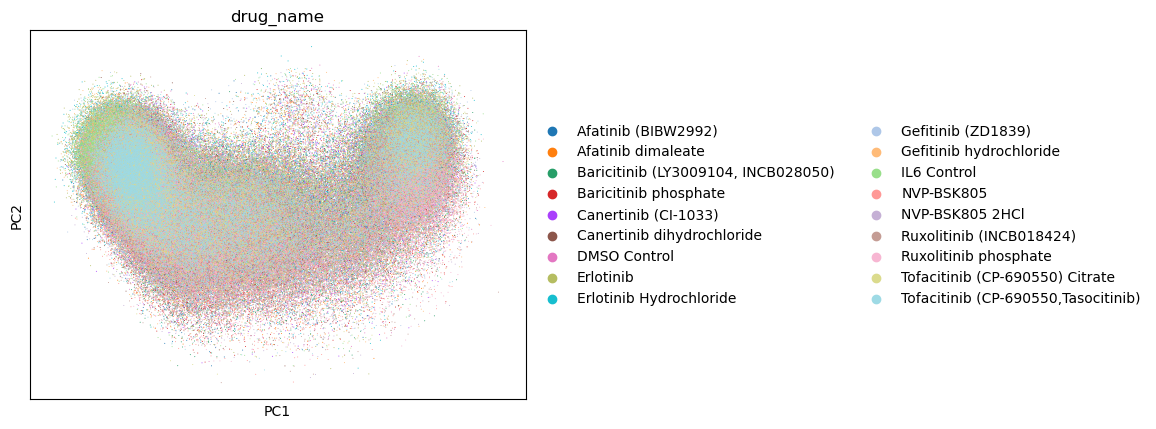

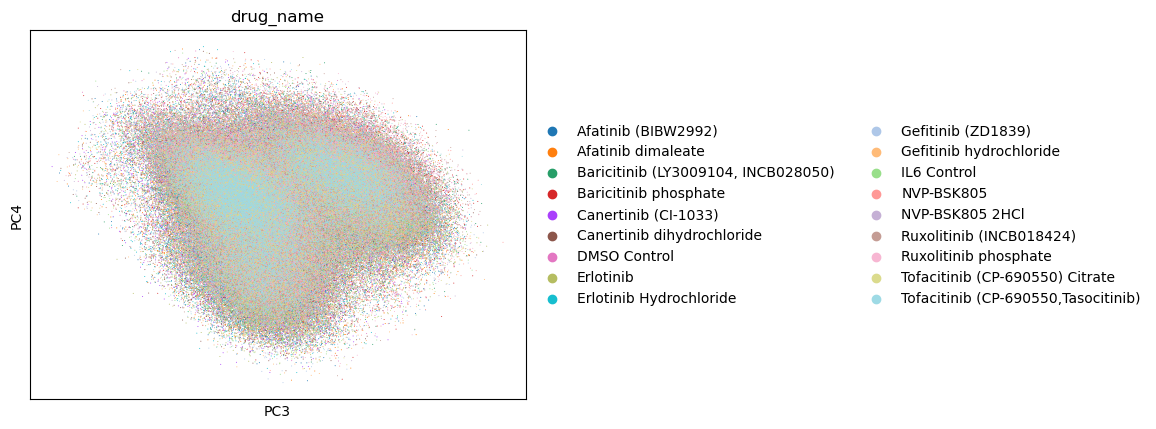

In [29]:
sc.pl.pca(
    adata,
    color = ["drug_name"],
    dimensions=[(0, 1)],
    ncols=2,
    size=2
)

sc.pl.pca(
    adata,
    color = ["drug_name"],
    dimensions=[(2, 3)],
    ncols=2,
    size=2
)

**QUESTION ABOUT INTERPRETATION: Check for drug treatment stuff:**

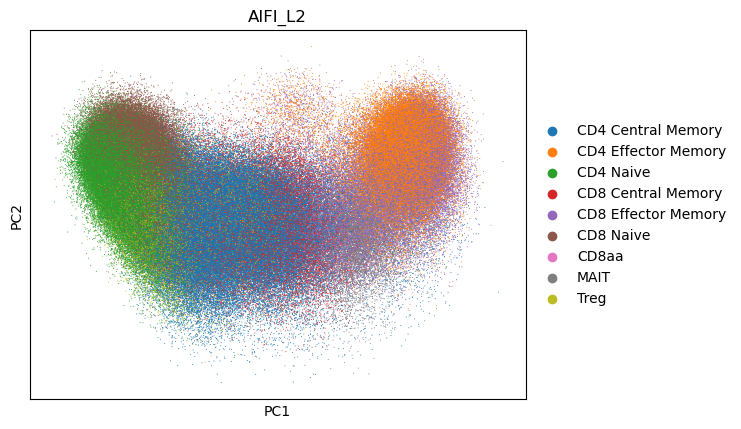

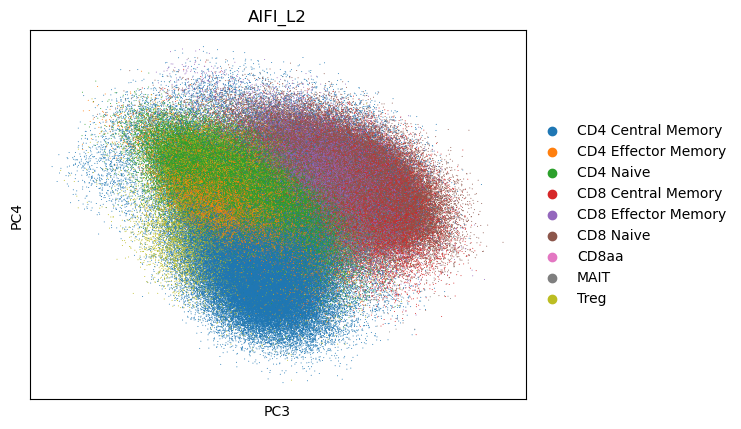

In [30]:
sc.pl.pca(
    adata,
    color = ["AIFI_L2"],
    dimensions=[(0, 1)],
    ncols=2,
    size=2
)

sc.pl.pca(
    adata,
    color = ["AIFI_L2"],
    dimensions=[(2, 3)],
    ncols=2,
    size=2
)

### Nearest neighbor graph construction and visualization: UMAP!

In [31]:
sc.pp.neighbors(adata)

In [32]:
sc.tl.umap(adata)

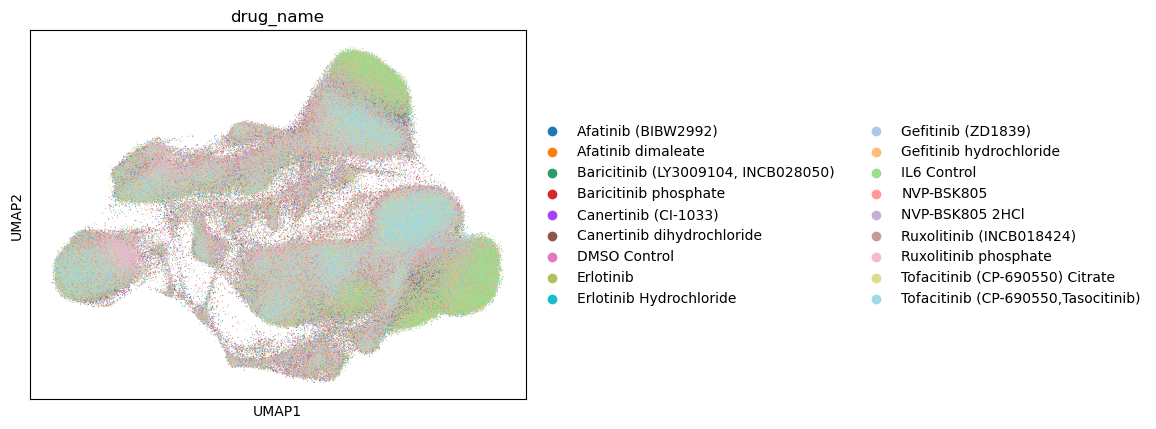

In [33]:
sc.pl.umap(
    adata,
    color="drug_name",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## Clustering

In [34]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster,
# especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

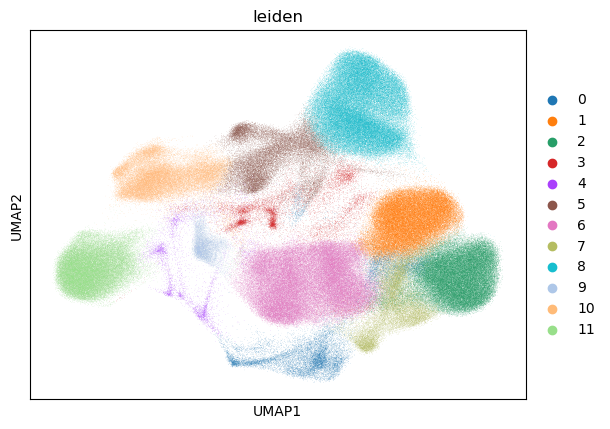

In [35]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering-- do we do this part?

## DEG mayhaps?
Seems we may need to filter our genes first (didn't fix it)

was getting log2 scanpy/numpy errors... those went away after commenting out scale() earlier, but now we have divide by zero errors when using the wilcoxon method.

In [64]:
sc.tl.rank_genes_groups(
    adata = adata,
    groupby = "drug_name",
    reference = "DMSO Control",
    method = "wilcoxon",
    tie_correct = True
)

/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:345: RuntimeWarning: invalid value encountered in divide
  scores = (
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:345: RuntimeWarning: invalid value encountered in divide
  scores = (
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:345: RuntimeWarning: invalid value encountered in divide
  scores = (
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:345: RuntimeWarning: invalid value encountered in divide
  scores = (
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:345: RuntimeWarning: invalid value encountered in divide
  scores = (
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:345: RuntimeWa

In [60]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'drug_name',
  'reference': 'DMSO Control',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('SBNO2', 'SBNO2', 'SLC5A6', 'SPOCK2', 'HMGB2', 'HMGB2', 'SBNO2', 'SBNO2', 'SBNO2', 'SBNO2', 'SBNO2', 'SQSTM1', 'SQSTM1', 'SLC5A6', 'SPOCK2', 'SBNO2', 'SBNO2'),
            ('BATF', 'BATF', 'SPOCK2', 'SLC5A6', 'TXNRD1', 'SBNO2', 'BATF', 'IFI16', 'BATF', 'BATF', 'IFI16', 'JUNB', 'JUNB', 'RRP12', 'SLC5A6', 'STAT3', 'STAT3'),
            ('VAV1', 'VAV1', 'RRP12', 'RRP12', 'SBNO2', 'TXNRD1', 'IFI16', 'BATF', 'NOTCH1', 'IFI16', 'BATF', 'DDIT4', 'SBNO2', 'SPOCK2', 'ADGRE5', 'CD7', 'MYC'),
            ...,
            ('BTG1', 'TRAC', 'NLRC5', 'NLRC5', 'BTG1', 'BTG1', 'CXCR4', 'TNFAIP3', 'CD5', 'CD5', 'LAT', 'PSMB9', 'IRF1', 'NLRC5', 'NLRC5', 'NLRC5', 'NLRC5'),
            ('TRAC', 'LAT', 'IRF1', 'IRF1', 'CXCR4', 'CXCR4', 'CD5', 'TXNIP', 'LAT', 'LAT', 'TRAC', 'NLRC5', 'NLRC5', 'IRF1', 'IRF1', 'IRF1', 'IRF1'